In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from pyswarms.single.global_best import GlobalBestPSO
import joblib

# Load your datasets
fake_data = pd.read_csv('Fake (1).csv')
true_data = pd.read_csv('True (1).csv')

# Create label columns (0 for true, 1 for fake)
true_data['label'] = 0
fake_data['label'] = 1
combined_data = pd.concat([true_data, fake_data], ignore_index=True)

# Assuming you have a 'text' column for the text data
X = combined_data['text'].values
y = combined_data['label'].values

# Tokenize and pad the text data
max_words = 10000
max_sequence_length = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_sequence_length)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Define the CNN model for feature extraction
def create_cnn_model(num_filters, kernel_size):
    embedding_dim = 100
    cnn_model = Sequential()
    cnn_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
    cnn_model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(1, activation='sigmoid'))
    cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn_model



# Define the fitness function for PSO
def fitness_function(x):
    num_filters, kernel_size = map(int, x[0][:2])  # Extract the first two elements from the array

    # Ensure num_filters is at least 1
    num_filters = max(num_filters, 1)

    # Ensure kernel_size is at least 1
    kernel_size = max(kernel_size, 1)

    cnn_model = create_cnn_model(num_filters, kernel_size)
    cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    y_pred = cnn_model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Minimize negative accuracy





# Define the PSO optimizer
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
n_particles = 10
dimensions = [(32, 3), (64, 5), (128, 5)]  # Range of filters and kernel sizes to optimize

# Optimize the CNN hyperparameters using PSO
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=len(dimensions), options=options)
best_cost, best_params = optimizer.optimize(fitness_function, iters=10)


ModuleNotFoundError: No module named 'keras'

In [3]:
# # Extract the best hyperparameters|
# best_params = best_params[0]  # Access the first element of the list
# best_num_filters, best_kernel_size = map(int, best_params[:2])  # Extract the first two elements

# Extract the best hyperparameters
best_params = best_params

# Extract the best_num_filters and best_kernel_size
best_num_filters, best_kernel_size = map(int, best_params[:2])  # Extract the first two elements



# Create and train the final CNN model with the best hyperparameters
best_cnn_model = create_cnn_model(best_num_filters, best_kernel_size)
best_cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
898/898 [==============================] - 14s 15ms/step - loss: 0.4271 - accuracy: 0.8395 - val_loss: 0.3245 - val_accuracy: 0.9085
Epoch 2/20
898/898 [==============================] - 14s 15ms/step - loss: 0.2722 - accuracy: 0.9260 - val_loss: 0.2378 - val_accuracy: 0.9315
Epoch 3/20
898/898 [==============================] - 15s 16ms/step - loss: 0.2002 - accuracy: 0.9418 - val_loss: 0.2017 - val_accuracy: 0.9342
Epoch 4/20
898/898 [==============================] - 14s 15ms/step - loss: 0.1618 - accuracy: 0.9527 - val_loss: 0.1924 - val_accuracy: 0.9381
Epoch 5/20
898/898 [==============================] - 14s 16ms/step - loss: 0.1403 - accuracy: 0.9594 - val_loss: 0.1895 - val_accuracy: 0.9392
Epoch 6/20
898/898 [==============================] - 13s 15ms/step - loss: 0.1278 - accuracy: 0.9626 - val_loss: 0.1866 - val_accuracy: 0.9376
Epoch 7/20
898/898 [==============================] - 14s 16ms/step - loss: 0.1198 - accuracy: 0.9647 - val_loss: 0.1899 - val_accuracy:

281/281 [==============================] - 1s 3ms/step
Accuracy with DT Classifier: 0.9300668151447662
Confusion Matrix:
 [[3991  339]
 [ 289 4361]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      4330
           1       0.93      0.94      0.93      4650

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



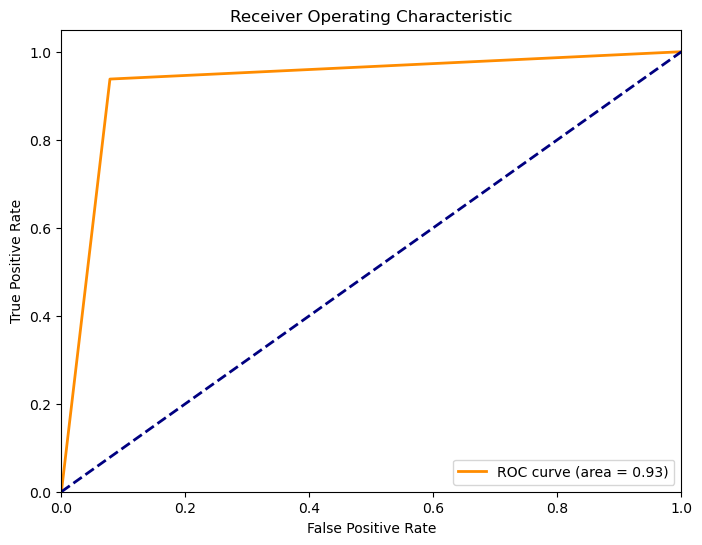

In [6]:
# Save the best-trained CNN model
best_cnn_model.save('best_cnn_model.h5')

# Extract CNN features
X_train_features = best_cnn_model.predict(X_train)
X_test_features = best_cnn_model.predict(X_test)

# Define and train the Decision Tree classifier
# Train the Decision Tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train_features, y_train)

# Save the model
joblib.dump(clf, 'decision_tree_classifier.joblib', compress=('zlib', 3), protocol=4)

# Make predictions
y_pred = clf.predict(X_test_features)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with DT Classifier:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


NameError: name 'best_cnn_model' is not defined